# Dino Bektesevic Exoplanets HW #1 part b
Jan 30, 2019

Write Julia code that can fit $P$, $e$, $t_p$, $gamma$ and $K$ to the planet whose RV measuraments are in the file mystery_planet01. 

In [1]:
using PyPlot;
using CSV;
using Statistics;
using Optim;

# 1. Finding the period P by phase folding 

## 1.1 Read the given data from the file

In [39]:
t = Float64[];
y = Float64[];
sigma = Float64[];
for row in CSV.File("mystery_planet1.txt", delim="\t")
    push!(t, row.t);
    push!(y, row.y);
    push!(sigma, row.sigma);
    end;

## 1.2 Sort and normalize the data

In [40]:
function sortByTime(t, y, sigma)
    tSortedIndx = sortperm(t);
    return t[tSortedIndx], y[tSortedIndx], sigma[tSortedIndx];
    end;

I'm removing any offset from 0 the total dataset might have by taking out the average value of the dataset from each datapoint. That recenters it on 0. I express all the time values relative to the first time-stamp. This is essentially placing the first time stamp to 0 and all the other steps are just relative time passed with respect to the time of the first observation. Data is sorted according to the timestamps such that every successive data point happened after the previous one.

In [41]:
t, y, sigma = sortByTime(t, y, sigma)
t = t .- t[1];
y = y .- mean(y);

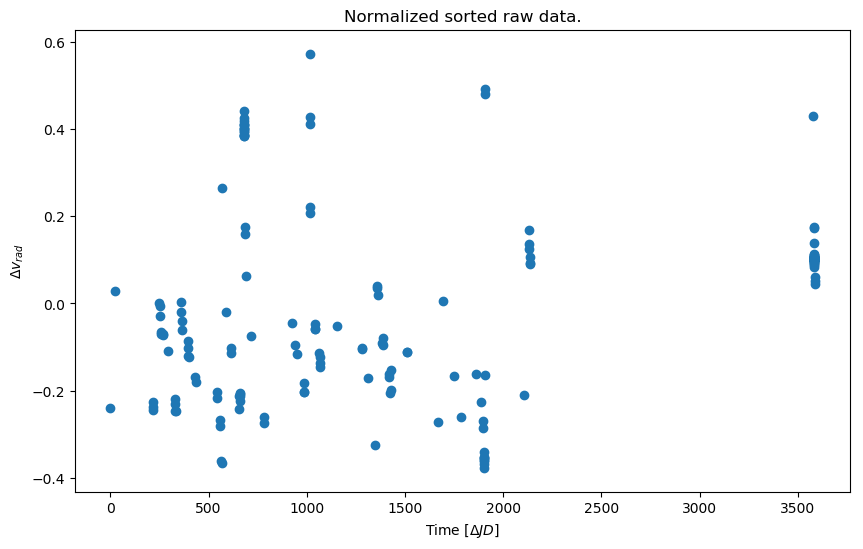

In [42]:
fig, ax = subplots(figsize=(10, 6))
scatter(t, y);
title("Normalized sorted raw data.")
xlabel(L"Time $[\Delta JD]$");
ylabel(L"$\Delta v_{rad}$");

# 1.3 Find the period by folding

The idea is to wrap all the RV measuraments around some test value of period T. When we find the value of T for which the selected period is just right to overlap the measuraments when the planet was in the same position on the orbit the sum of squares of differences of velocities should be minimal.

In [6]:
function foldOnT(t, t_fold)
    return t .% t_fold
    end;

function sumDist(y, sigma)  
    dv = y[1:end-1] .- y[2:end]
    return sum(dv.^2) 
    end;

In [7]:
function findPeriod(t, y, sigma; start=0, endt=1000, stept=0.01)
    minP, minT, minV, minErr = -1, 0, 0, 0
    minDist = sumDist(y, sigma)
    
    for (i, testP) in enumerate(start:stept:endt)
        testT = foldOnT(t, testP)
        testT, testV, testErr = sortByTime(testT, y, sigma)
        dist = sumDist(testV, testErr)
        if dist < minDist
            minP = testP
            minT = testT
            minV = testV
            minErr = testErr
            minDist = dist
            end;
        end;
    print("Minimal found P: $minP")
    return minP, minT, minV, minErr;
    end;

In [8]:
period, minT, minV, minErr = findPeriod(t, y, sigma);

Minimal found P: 111.47

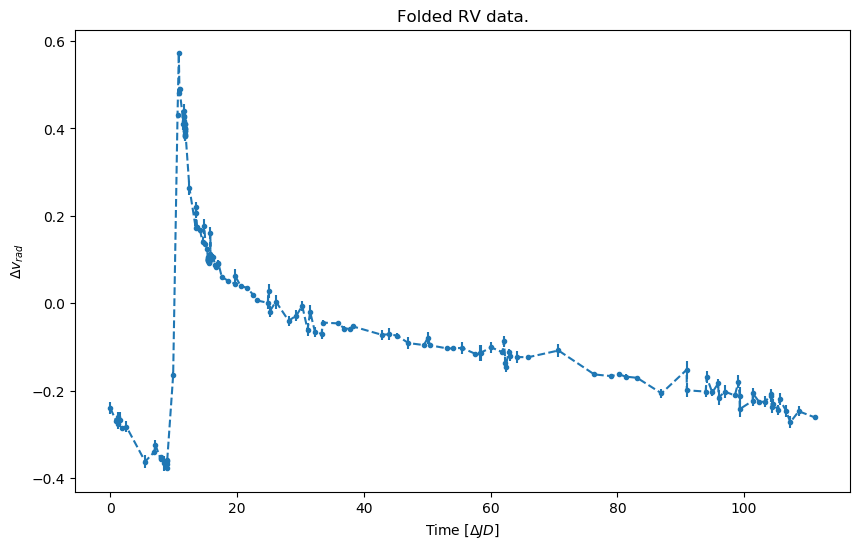

In [9]:
fig, ax = subplots(figsize=(10, 6))
errorbar(minT, minV, minErr, marker="o", ms=3, ls="--");
title("Folded RV data.")
xlabel(L"Time $[\Delta JD]$");
ylabel(L"$\Delta v_{rad}$");

With the period P down, only 4 more parameters to go.

# 2. Fitting $e$, $t_p$, $\gamma$ and $K$

## 2.1 Defining goodness of fit test and our model.

Goodness of fit test used is the chi-square test.

$$\chi^2 = \sum \frac{(x_i - m_i)^2}{\sigma_i^2}$$

Where the mmodel data is generated by the following model:

$$v_{rad} = h\cos(f)+c\sin(f)+v_0$$

where the values $h$, $c$, $v_0$ and $f$ are given by the following expressions:
$$\begin{eqnarray}
h &=& K\cos(\omega)  \\
c &=& -K\sin(\omega) \\
v_0 &=& \gamma + Ke\cos(\omega) \\
f &=& 2\arctan\left[ \left( \frac{1+e}{1-e} \right)^{\frac{1}{2}} \tan\frac{E}{2} \right]
\end{eqnarray}$$

The idea is that we find a minimal set of parameters we have to pick, that is still sufficiently large enough to calculate all the required parameters based on the observed light curve. The smaller the selected set the lower the dimensions of parameter space we need to explore to find the best matching fit, which translates into faster fits.

Further reducing the expressions for K will not reduce the number of parameters we have to explore even under the assumptions of a circular orbit of an edge-on system where the stellar mass is much larger than the planets. Looking at the expression for $K$

$$ K = \left[ \frac{2\pi G}{m_S+m_p} \frac{m_p^3\sin^3i}{P(1-e^2)^{\frac{3}{2}}}  \right]^{\frac{3}{2}} $$

we see that we would just be adding $\omega$ and $m_S$ as additional parameters we have to fit or pick. Best way forward is set by prescription given by Wright and Howard. From the chi-square test we can write:

$$\begin{eqnarray}
\chi^2 &=&&& \sum \frac{(v_i - (h_i\cos f_i+c\sin f_i+v_{0i}))^2}{\sigma_i^2} \\
\frac{\partial\chi^2}{\partial h} &=& 0 &=& \sum \frac{2(v_i - (h_i\cos f_i+c_i\sin f_i+v_{0i}))(-\cos f_i)}{\sigma_i^2} \\
\frac{\partial\chi^2}{\partial c} &=& 0 &=& \sum \frac{2(v_i - (h_i\cos f_i+c_i\sin f_i+v_{0i}))(-\sin f_i)}{\sigma_i^2} \\
\frac{\partial\chi^2}{\partial v_0} &=& 0 &=& \sum \frac{2(v_i - (h_i\cos f_i+c_i\sin f_i +v_{0i}))(-1)}{\sigma_i^2}
\end{eqnarray}
$$

where $h_i$, $f_i$, $v_0i$ etc. just indicate the values of those parameters at a time corresponding to the measurament $v_i$ for a particular selection of parameters of those functions. Setting the partial derivatives to zero will find the extremes of that chi-square function. It is precisely at a minimum of the chi-square function where we wish to evaluate $h$, $f$ and $v_0$. Writing these equations out (multiply with the derivative, separate the sum into two on the $v_i$ element) and expressing them in matrix form for a system of equations the sums take the following form:

$$\begin{bmatrix}
\sum\frac{\cos^2f_i}{\sigma_i^2} & \sum\frac{\sin f_i\cos f_i}{\sigma_i^2} & \sum\frac{\cos f_i}{\sigma_i^2} \\
\sum\frac{\sin f_i\cos f_i}{\sigma_i^2} & \sum\frac{\sin^2 f_i}{\sigma_i^2} & \sum\frac{\sin f_i}{\sigma_i^2} \\
\sum\frac{\cos f_i}{\sigma_i^2} &  \sum\frac{\sin f_i}{\sigma_i^2} & \sum\frac{1}{\sigma_i^2}
\end{bmatrix} \begin{bmatrix}h \\ c \\ v_0\end{bmatrix} = \begin{bmatrix}\sum\frac{v_i \cos f_i}{\sigma_i^2} \\ \sum\frac{v_i \sin f_i}{\sigma_i^2} \\ \sum\frac{v_i}{\sigma_i^2} \end{bmatrix}$$

To calculate the $h$, $c$ and $v_0$ analytically, however, we need $f$. To get $f$ we need to pick both eccentricity $e$ and eccentric anomaly $E$. We can avoid having to pick $E$ by framing the given expression for $f$ in terms of mean anomaly $M$:

$$ M = \frac{2\pi}{P}(t-t_p) = E - e\sin E = 0$$

pick $t_p$ and apply the solution from HW1 to find $f$. Now we can vary $e$, $P$ and $t_p$, numerically solve for $f$, analytically solve for $h$, $c$, and $v_0$, evaluate our model $v_{rad}$ and calculate the $\chi^2$ value. Picking the smallest $\chi^2$ value should yield the best fit of the model to the data given the parameters $e$, $P$ and $t_p$.

Just to make it clearer here it is again:

* pick $e$, $P$, $t_p$ 
* evaluate corresponding $M$
* numerically solve for $f$ as in HW1.
* analytically solve for $h$, $c$, and $v_0$ by solving the system above
* evaluate our model $v_{rad}(t, e, P, t_p, h, c, v_0)$ on the same grid of times $t$ as measuraments
* calculate $\chi^2$ 

## 2.2 Newtons method based solved for Kepler equation from HW1.

In [10]:
function newtonsMethod(f, fdot, starting_guess; precission=0.01)
    f_x = f(starting_guess)
    fdot_x = fdot(starting_guess)
    
    previous = starting_guess
    next = starting_guess - f_x/fdot_x
                
    while abs(next-previous) > precission
        previous = next
        next = previous - f(previous)/fdot(previous)
        end;
    
    return next;
end;   

function keplersEq(E, M, e)
    return E-e*sin(E)-M;
end;
    
function keplersEqDot(E, M, e)
    return 1-e*cos(E);
    end;
    
function guessE(M, e)
        return M+0.85*e*sign(sin(M));
    end;

function newtonKeplerSolver(M, e; precission=0.0001)
    E = guessE(M, e);
    f(E) = keplersEq(E, M, e);
    fdot(E) = keplersEqDot(E, M, e);
    return newtonsMethod(f, fdot, E, precission=precission);
    end;

## 2.2 System of equations solver 

Solves they matrix system as defined above. The Kepler solver from HW1 was tested only on 0-360 not more, so in solveF we wrap it and deal with that. In solveHCV we essentially manually write the matrix system $\mathbf{A}\mathbf{x}=\mathbf{b}$ and leave the solving to Julia by doing $\mathbf{A}/\mathbf{b}$.

In [11]:
function solveF(M, e; returnAll=false)        
    E = Float64[];
    for (i, m) in enumerate(M)
        while m < 0
            m += 2*pi;
            end;
        while m > 2*pi
            m -= 2*pi;
        end;
        push!(E, newtonKeplerSolver(m, e));
        end;

    f = 2 * atan.( sqrt( (1+e)/(1-e) ) * tan.(E./2) );
    if returnAll
        return f, E, M
        end;
    return f;
    end;

function solveHCV(y, sigma, f; returnAll=false)
    cosf = cos.(f);
    sinf = sin.(f);
    
    cosf2 = cosf .^ 2;
    sinf2 = sinf .^ 2;
    
    sincosf = cosf .* sinf;
    err2 = sigma .^ 2;
    
    A = zeros(3,3);
    A[1,1] = sum(cosf2 ./ err2);
    A[1,2] = sum(sincosf ./ err2);
    A[1,3] = sum(cosf./ err2);

    A[2,2] = sum(sinf2 ./ err2);
    A[2,3] = sum(sinf ./ err2);
    
    A[3,3] = sum(1 ./ err2);
    
    A[2,1] = A[1,2];
    A[3,1] = A[1,3];
    A[3,2] = A[2,3];

    b = zeros(3)
    b[1] = sum(y .* cosf ./ err2);
    b[2] = sum(y .* sinf ./ err2);
    b[3] = sum(y ./ err2);

    #h,c,v_o = A\b
    if returnAll
        return A\b, A, b, cosf, sinf, err2;
        end;
    return A\b;
    end;

## 2.3 Define the model

In [12]:
function evaluateModel(t, e, P, t_p, h, c, v_o)
    Ms = 2*pi/P .* (t .- t_p)       
    E = zeros(length(t))
    for (ii, M) in enumerate(Ms)
        E[ii] = newtonKeplerSolver(M, e)
    end
    
    fs = 2 .* atan.( ((1+e)/(1-e))^0.5 * tan.(E./2) )
    
    vModel = h .* cos.(fs) .+ c .* sin.(fs) .+ v_o
    return vModel
end  

function fitModel(t, y, sigma, e, P, t_p; returnAll=false)   
    M = (2*pi/P) .* (t .- t_p);
  
    f = solveF(M, e);
    
    (h, c, v0), A, b, cosf, sinf, err2 = solveHCV(y, sigma, f, returnAll=true);
    
    mi = h .* cosf .+ c .* sinf .+ v0;

    if returnAll
        return mi, f, h, c, v0, err2, cosf, sinf
        end;
    return mi;
    end;

## 2.4 Write the Chi-Square test and fitter

The Optim package will do what seems to be a gradient descent algorithm to direct how data is sampled. Since sometimes it like to make an excursion into unphysical values we will discourage it from doing that by manually returning large values in the unphysical limits.

Naturally there's a case to be made that if any of our fitted for parameters were close to these cut-offs the optimizer would have a hard time fitting there but since I've seen what the data looks like and am confident that this is not the case for this particular planet I did it anyway. 

A better way would be to modify the equations to return lets say exponentially larger values further into unphysical area we went than having a "wall" at that boundary.

In [13]:
function chiSquareTest(t, y, sigma, e, P, t_p)
    mi, f, h, c, v0, err2, cosf, sinf = fitModel(t, y, sigma, e, P, t_p, returnAll=true);
    chi2 = sum( (y .- mi).^2 ./ err2 );
    return chi2, h, c, v0;
    end;

function boxedChiSquareTest(x)
    if (x[1]<0) || (x[1]>1)
        return 999999999999999;
        end;
    if (x[2]<0) || (x[3]<0)
        return 999999999999999;
        end;
    
    # binds to the global t, y, sigma
    chi2, h, c, v0 = chiSquareTest(t, y, sigma, x[1], x[2], x[3])
    return chi2;
    end;

# 3. Fit and evaluate the fit

In [14]:
initial = [0.9, period, 5];
results = optimize(boxedChiSquareTest, initial);
eFit, PFit, t_pFit = Optim.minimizer(results);
println("Fit returned e: $eFit,   P: $PFit,   t_p: $t_pFit,   min(chi^2): $(results.minimum) \n")
results

Fit returned e: 0.9255409802374217,   P: 111.4670212219506,   t_p: 10.570929756073266,   min(chi^2): 1282.9014578328383 



Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [0.9,111.47,5.0]
 * Minimizer: [0.9255409802374217,111.4670212219506, ...]
 * Minimum: 1.282901e+03
 * Iterations: 227
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 437

In [15]:
mi, f, h, c, v0, err2, cosf, sinf = fitModel(t, y, sigma, eFit, PFit, t_pFit, returnAll=true);
println("Fit returned h: $h,   c: $c,   v_0: $v0 \n")

Fit returned h: 0.2285852821899427,   c: 0.3682670757756651,   v_0: 0.0876397153391166 



In [16]:
gamma = v0 - eFit * h
K = sqrt(h^2+c^2)
omega = acos(h / K) * 360 / (2*pi)
print("Fit returned gamma: $gamma,   K: $K,   omega: $omega \n")

Fit returned gamma: -0.12392533080681062,   K: 0.43344188807061,   omega: 58.17191123188605 


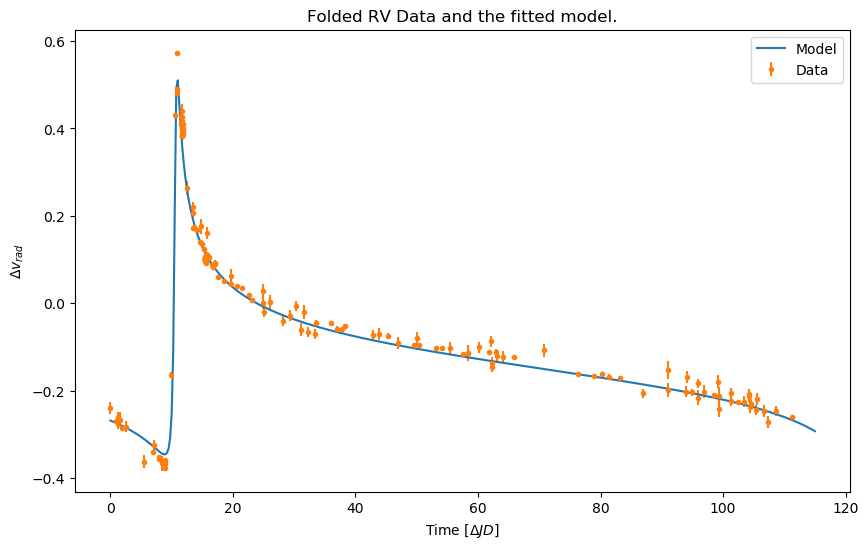

In [17]:
tst = range(0, 115, step=0.25)
mi  = evaluateModel(tst, eFit, PFit, t_pFit, h, c, v0);

fig, ax = subplots(figsize=(10, 6))
plot(tst, mi, label="Model");
errorbar(minT, minV, minErr, marker="o", ms=3, ls="", label="Data");
xlabel(L"Time $[\Delta JD]$");
ylabel(L"$\Delta v_{rad}$");
title("Folded RV Data and the fitted model.")
legend();

I have a hard time believing the Optim optimizer. It is quite unstable and. For example: 

* initial guesses of $e=0.95$ and $t_p=1$ return $e=2.6.e-12$, $P=160.55$, $t_p=1.54$ at $\chi^2=88275$
* but $e=0.9$ and $t_p=1$ give back $e=0.99$, $P=146.4$, $t_p=0.68$ at $\chi^2=99201$

notice how for a 0.05 change in eccentricity the eccentricity jumped from tending to 0 to tending to 1. If I keep increasing initial $t_p$ guess, while keeping $e=0.9$, at around $t_p=4$ values reported earlier (0.93, 111.4, 10.9 at chi2 317) will reappear. I believe this the most accurate fit majority of the initial values tend to it. Anyhow the values of $\chi^2$ were too big too ignore so I evaluated the model on a grid as well (this was actually done first and then Optim was tried second).

Grid evaluation was done by setting the period to the one returned by the folding periodogram and then varying $e$ and $t_p$.

In [33]:
period

111.47

In [34]:
function gridEvaluate(e, tp; P=period)
    chi2full = zeros(length(e), length(tp))
    for (i, et) in enumerate(e)
        for (j, tt) in enumerate(tp)
            chi2, h, c, v0 = chiSquareTest(t, y, sigma, et, P, tt)
            chi2full[i, j] = chi2  
            end;
        end;
    chi2full = 1 .* transpose(chi2full);
    end;

function statsifyGrid(chi2; e=nothing, tp=nothing)  
    min = minimum(chi2);
    indices = findall(x->x==min, chi2);
    minx = indices[1][2];
    miny = indices[1][1];
    
    println("The minimum value of the grid is $min at indices ($minx, $miny). \n"); 
    if (e!=nothing) && (tp!=nothing)
        eminx = e[minx];
        tpminy = tp[miny];
        println("    The value of e[$minx]= $eminx.");
        println("    The value of t_p[$miny]= $tpminy.");
        end;
        
    return minx, miny;
    end;
    
function plotGridEval(chi2, e, tp; minx=0, miny=0, efit=0, tpfit=0, ux=0, uy=0, logged=true)   
    fig, ax = subplots(figsize=(16, 9));
        
    if logged
        pltchi = log.(chi2)
    else
        pltchi = chi2
    end;
        
    xmin = e[1];
    xmax = e[end];
    ymin = tp[1];
    ymax = tp[end];
        
    ims = imshow(pltchi, origin="lower", interpolation="none", aspect="auto", extent=(xmin, xmax, ymin, ymax))
        
    xlabel("Eccentricity");
    ylabel("Time to perihelion");
       
    if (efit!=0) && (tpfit!=0)
        axvline(eFit, color="white", label="Optim fit");
        axhline(t_pFit, color="white");
        legend()
        end;
    
    if (minx!=0) && (miny!=0)
        scatter(e[minx], tp[miny], marker="o", s=100, color="white", facecolors="none", label="Grid min");
        legend()
        end;
    
    if (ux!=0) && (uy!=0)
        scatter(e[ux], tp[uy], marker="o", s=10, color="white", facecolors="none", label="User target");
        legend()
        end;
    
    cbar = colorbar(ims);
    cbar[:set_label](L"\log\chi^2");
    
    xlim(xmin, xmax);
    ylim(ymin, ymax);
    title("Grid evaluated chi^2 test.");
    end;

In [19]:
efull  = range(0.8, 0.9999, step=0.001)
tpfull = range(0.1, 12.5, step=0.01)
chi2full = gridEvaluate(efull, tpfull);
(minxf, minyf) = statsifyGrid(chi2full, e=efull, tp=tpfull);

The minimum value of the grid is 1314.6580716882386 at indices (127, 1040). 

    The value of e[127]= 0.926.
    The value of t_p[1040]= 10.49.


In [45]:
ezoom  = range(0.920, 0.97, step=0.0001)
tpzoom = range(8, 11.5, step=0.01)
chi2zoom = gridEvaluate(ezoom, tpzoom);
(minxz, minyz) = statsifyGrid(chi2zoom, e=ezoom, tp=tpzoom);

The minimum value of the grid is 317.59455723755894 at indices (123, 293). 

    The value of e[123]= 0.9322.
    The value of t_p[293]= 10.92.


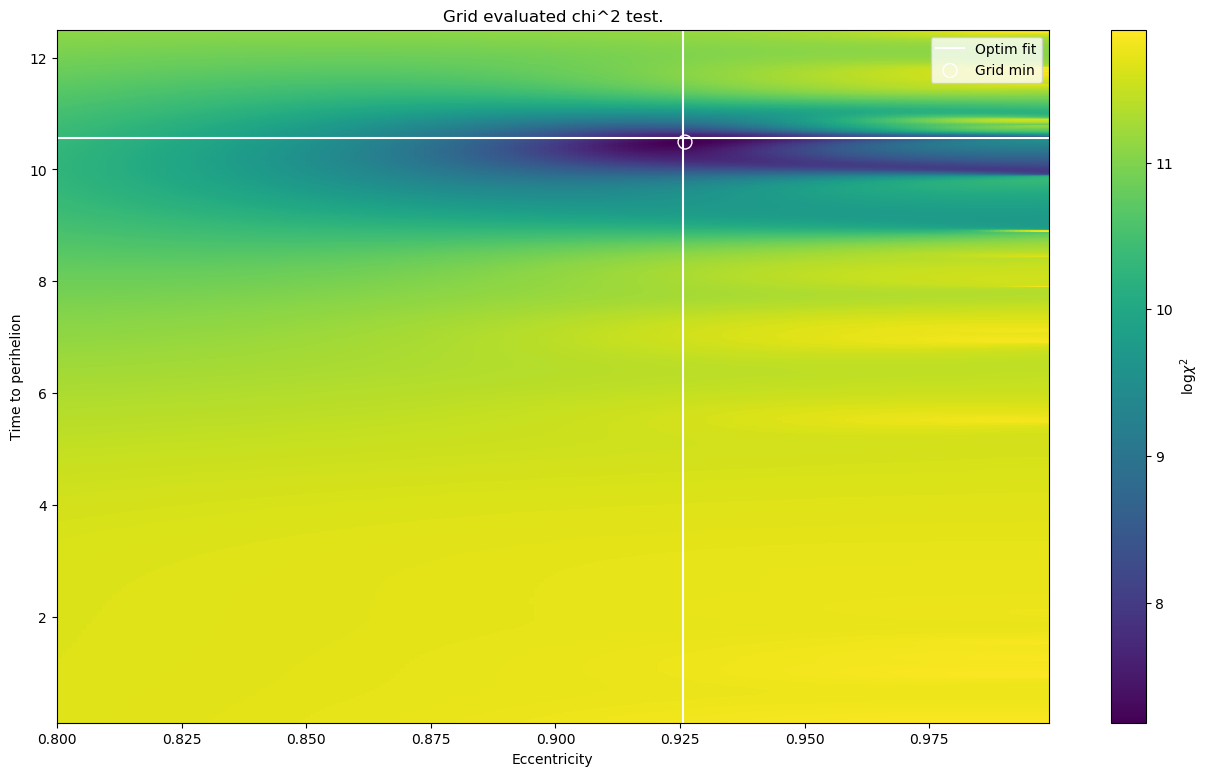

In [21]:
plotGridEval(chi2full, efull, tpfull, efit=eFit, tpfit=t_pFit, minx=minxf, miny=minyf);

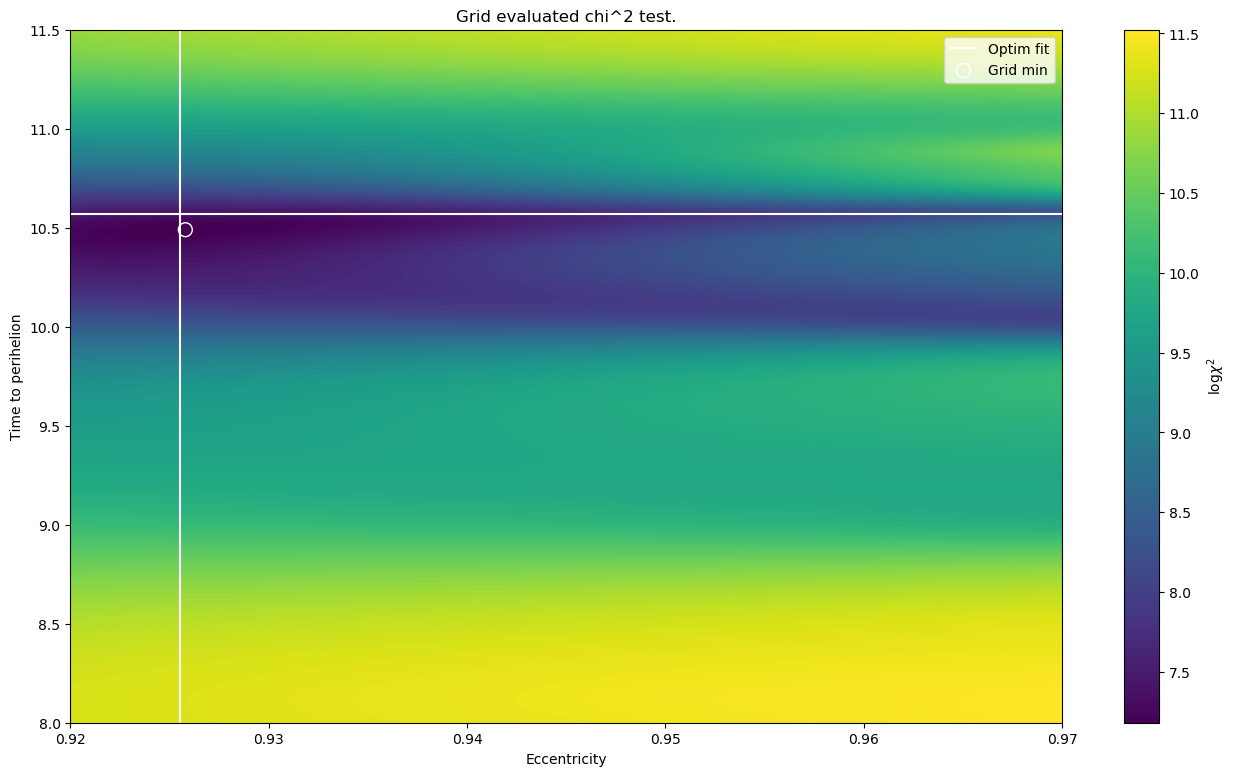

In [22]:
plotGridEval(chi2zoom, ezoom, tpzoom, efit=eFit, tpfit=t_pFit, minx=minxz, miny=minyz);

In [46]:
mi, f, h, c, v0, err2, cosf, sinf = fitModel(t, y, sigma, ezoom[minxz], PFit, tpzoom[minyz], returnAll=true);
println("Fit returned h: $h,   c: $c,   v_0: $v0")
gamma = v0 - ezoom[minxz] * h
K = sqrt(h^2+c^2)
omega = acos(h / K) * 360 / (2*pi)
print("Fit returned gamma: $gamma,   K: $K,   omega: $omega")

Fit returned h: 0.3663484857684302,   c: 0.3442183359950807,   v_0: 0.21549591757515002
Fit returned gamma: -0.12601414085818063,   K: 0.5026902384769809,   omega: 43.21613616245514

So it is obvious that the manual grid search resolved greater detail than the Optim package could. To compare the, minor, changes to the end fit values look at the table below:

| Param | Optim   | Grid   |
|-------|---------|--------|
| e     |   0.925 | 0.9258 |
| P     | 111.467 | 111.47°|
| tp°°  |  10.571 |  10.49 |
| h     |   0.228 |  0.219 |
| c     |   0.368 |  0.372 |
| v0°°° |   0.087 |  0.080 |
| gamma |  -0.124 | -0.123 |
| K     |   0.433 |  0.432 |
| omega |  58.172 | 59.523 |

° Period fitted via folding                         
°° tp is relative to the first timestamp at 2.451293846e6               
°°° relative to the mean value taken out at the start 0.11501091954022993                 
°°°° Also note that outputs of cells might not correspond to the values in the tables as the cells have been run after writing the table down.

Looking through the database found at http://exoplanets.org/table there are only 3 planets with eccentricities greater than 0.9. Out of the three availible only one has a period that matches to the ones retrieved via model fitting: http://exoplanets.org/detail/HD_80606_b . The velocity periodogram matches quite well to the one we have but none of the other parameters really do - namely v0 and $gamma$ (even after correcting for the rescaling at the start) does not approach the 470m/s listed for that planet. 

Still, seeing how there are no other real options that fit better the planet has been identified as HD80606b.